# Group: DAX30

Team Members:  
- 107301029 國貿四 陳興穎
- 108208048 經濟三 莫賜天
- 108302062 金融三 林隆鴻
- 108302006 金融三 黃冠綸
- S11010102 中央財金 陳騰翔

# 110-1-301813001/351950001 
## Investment and Portfolio Management - Group Project 
### Part 1: Index Replication *[15 points]*
In this part, you will **replicate a stock market index of your choice (must be different from other groups)** using **Yahoo! Finance data from 2021-01-01 to 2021-11-30**. You will have to complete the following tasks:
1. Construct the following indices using the index constituents *[12 points]*:
    * **Price-weighted (PW) index** *[4 points]*;
    * **Value-weighted (VW) index** *[4 points]*;
    * **Equal-weighted (EW) index** *[4 points]*.
2. Plot the **original index** and the **three constructed indices (initial value of 100)** *[3 points]*.

#### Step1: Get data

In [1]:
import numpy as np 
import pandas as pd 
import yfinance as yf
import matplotlib.pyplot as plt

page = pd.read_html("https://en.wikipedia.org/wiki/DAX")
tickers = page[3].iloc[:,3]

dax = pd.DataFrame()
df_mcap = pd.DataFrame()

for i in tickers:
    data= yf.download(i,interval="1d",start="2021-01-05",end="2021-11-30")
    
    data= pd.DataFrame(data["Adj Close"])
    data.columns= [i]
    dax= pd.concat([dax,data],axis=1)
    
    
    stk= yf.Ticker(i)
    try:
        stk.info["floatShares"]
    except:
        stk.info["floatShares"]= None
    try:
        stk.info["sharesOutStanding"]
    except:   
        stk.info["sharesOutStanding"] = None
    if stk.info["floatShares"]:
        mcap = data * stk.info["floatShares"]
    elif stk.info["sharesOutStanding"]:
        mcap = data * stk.info["sharesOutStanding"]
    else:
        mcap = data * (stk.info["marketCap"]/stk.info["previousClose"])
        
    df_mcap = pd.concat([df_mcap,mcap],axis=1) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

#### Step2. Calculate returns and visualization

In [2]:
PWI = dax.sum(axis=1)
PWI = pd.DataFrame(PWI.rename("PWI"))


EWI= dax.pct_change().mean(axis=1)
EWI[0]=0
EWI += 1
EWI = EWI.cumprod()
EWI = pd.DataFrame(EWI.rename("EWI"))

VWI = df_mcap.sum(axis=1)
VWI = pd.DataFrame(VWI.rename("VWI"))

DAX_Index = pd.DataFrame( yf.download("DAX",interval="1d",start="2021-01-05",end="2021-11-30")["Adj Close"])
DAX_Index.columns=["Actual DAX"]

[*********************100%***********************]  1 of 1 completed


<Figure size 1080x720 with 0 Axes>

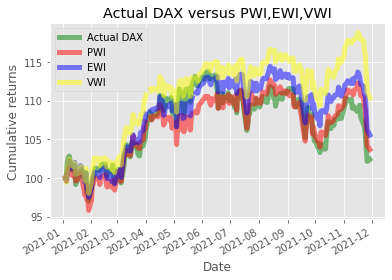

In [3]:
TS = DAX_Index.join([PWI,EWI,VWI])
TS = TS/TS.iloc[0]*100

plt.style.use("ggplot")
plt.figure(figsize=(15,10))

fig = TS.plot(color=["Green","red","blue","yellow"],alpha=.5,linewidth=5)
plt.title("Actual DAX versus PWI,EWI,VWI")
plt.legend(loc="best")
plt.ylabel("Cumulative returns")
plt.show()

### Part 2: Modern Portfolio Theory *[15 points]*

In Lecture 7, we learn how to conduct backtesting and solve for optimal portfolios numerically. Now, you have to compare the **out-of-sample performance** of **analytical optimal portfolios** and **numerical constrained portfolios**. Your code should do the following:

1. Using **Fama-French 17 Industries Portfolios from 1980 until 2021**, conduct back-testing on the following strategies *[12.5 points]*:
    * **MSRP (analytical)** *[2.5 points]*;
    * **GMVP (analytical)** *[2.5 points]*; 
    * **MSRP no short-selling (numerical)** *[2.5 points]*; 
    * **GMVP no short-selling (numerical)** *[2.5 points]*; 
    * **Equal-weighted (EW) portfolio** *[2.5 points]*.
2. Plot the **cumulative returns** of **all five strategies** *[2.5 points]*.

#### Bonus *[15 points]*:
1. **Apply shrinkage method** to estimate **expected returns** and **variance-covariance matrices** *[5 points]*.
2. **Reduce computation time** through **parallel computing** *[10 points]*.

#### Step1. Get the data and define functions

In [4]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

cmap = sns.color_palette()

In [5]:
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1980')
asset = pdr.get_data_famafrench('17_Industry_Portfolios', start='1-1-1980')

df_FF = factor[0].loc['1980':'2021']
df_R = asset[0].loc['1980':'2021']
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1)

#### Step2. Backtest

In [6]:
S = df_R.cov()
R = df_R.mean(axis=0)
ER = df_ER.mean(axis=0)
N = len(ER)
ONE = np.ones(len(ER))

In [7]:
from scipy.optimize import Bounds

def GMVP(S): # for analytical GMVP
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)

def MSRP(ER, S): # for analytical MSRP
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)



def pvar(w, S): # for numerical GMVP
    return (w.T @ S @ w)

def sharpe(w, ER, S): # for numerical MSRP
    return -(w.T @ ER)/np.sqrt(w.T @ S @ w)


def NGMVPnoSS(S): # for numerical GMVP
    x0 = GMVP(S)
    cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)

    return minimize(pvar, x0, method='SLSQP', constraints=cons, args=S, 
    options={'disp': True, 'ftol': 1e-9},
    bounds=bounds
    )

def NMSRPnoSS(ER, S): # for numerical MSRP
    x0 = MSRP(ER, S)
    cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
    bounds = Bounds(0, 1)

    return minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
    options={'disp': True, 'ftol': 1e-9},
    bounds=bounds)

def pret(w, ER): 
    return (w.T @ ER)

In [8]:
import timeit
start = timeit.default_timer()

WSize = 60 # rolling period: 5 years
AvgER_rolling = df_ER.rolling(WSize).mean() 
CovER_rolling = df_ER.rolling(WSize).cov() 

Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP', 'NGMVPnoSS', 'NMSRPnoSS', 'EW'])

for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]

    Backtest_R.loc[d,'GMVP'] = pret(GMVP(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(MSRP(ER, S), R) 
    Backtest_R.loc[d, 'NGMVPnoSS'] = pret(NGMVPnoSS(S).x, R) # x is the weight array we need 
    Backtest_R.loc[d, 'NMSRPnoSS'] = pret(NMSRPnoSS(ER, S).x, R)


# EW
Backtest_R.loc[:,'EW'] = df_R.mean(axis=1)

Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):]

stop = timeit.default_timer()
print('Time: ', stop - start)  

Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 2908
            Gradient evaluations: 101
Iteration limit reached    (Exit mode 9)
            Current function 

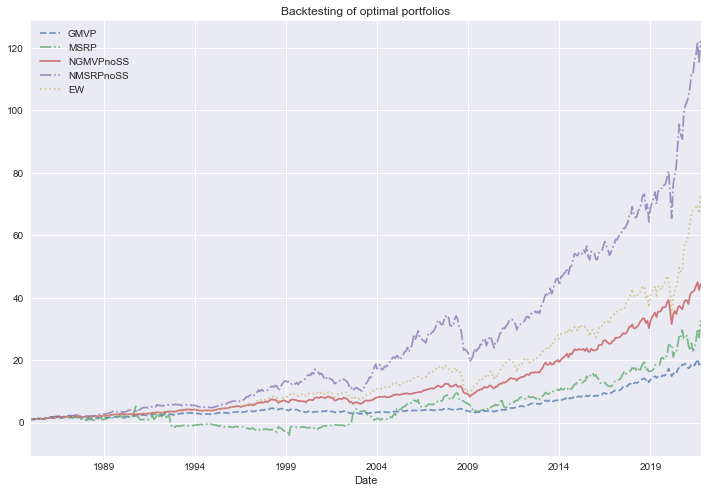

In [9]:
plt.style.use('seaborn')
plt.figure(figsize=(12, 8))

CumRet = (1 + Backtest_R.divide(100)).cumprod() 
CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['NGMVPnoSS'].plot(alpha=0.75, linestyle="solid")
CumRet['NMSRPnoSS'].plot(alpha=0.75, linestyle="dashdot")
CumRet['EW'].plot(alpha=0.75, linestyle=":")

plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()

### Part 3: CAPM Estimations *[10 points]*

In lecture 9, we discuss how to estimate CAPM betas of individual stocks and the security market line (SML). Using the **index constituents** from **Part 1**, write a code that performs the following:

1. Estimate **CAPM betas** for **all the index constitutents in Part 1** *[5 points]*.
2. Plot the **average returns** of the index constituents *[2.5 points]*.
3. On the same diagram, plot the **CAPM predicted SML** and **empirical SML** implied by the index constituents *[2.5 points]*.

#### Step1: Get data

In [10]:
DAX_Index = pd.DataFrame( yf.download("DAX",interval="1d",start="2021-01-05",end="2021-11-30")["Adj Close"])
DAX_Index.columns=["Actual DAX"]

mkt_retuns = DAX_Index.pct_change().dropna()
returns = dax.pct_change().dropna()

df = mkt_retuns.join(returns).dropna()

[*********************100%***********************]  1 of 1 completed


#### Step2: Calculate betas

In [11]:
import statsmodels.api as sm

MKT = df["Actual DAX"] 
RF = 0 # risk-free rate = 0%

AvgMkt = MKT.mean()
AvgRF = 0

BETA = []
AvgR = []
AvgRHat = []

for c in range(dax.shape[1]): 
    R = (df.iloc[:,c+1]) #We use plus 1 since we dont want to use the first column because it is the market index
    TSR = sm.OLS(R, sm.add_constant(MKT)).fit()
    print(TSR.params[1])
    BETA.append(TSR.params[1])
    AvgR.append(R.mean())
    AvgRHat.append(AvgMkt * TSR.params[1])

0.9708955778248423
0.7232679539712686
0.8801529561967906
0.6408119759477154
0.9278588083262701
1.002913404951687
0.925309548359898
0.9342566387712662
0.6592773932152163
1.102177439728277
0.4313046886658268
0.8673605525570609
0.5449706713684028
0.16542571494050795
0.35547891216310357
0.45277343187318436
0.2262538307971587
0.8975322419004709
0.46077266765055047
1.2597695187201239
0.7796385448022852
0.40795998331258504
0.9149649695186624
0.8112615099357259
0.6186521269594075
0.7369395628338979
1.1007522780995684
0.8737709204028375
1.1355661737575968
0.36207315665661444


#### Step3: Visualization of empirical SML

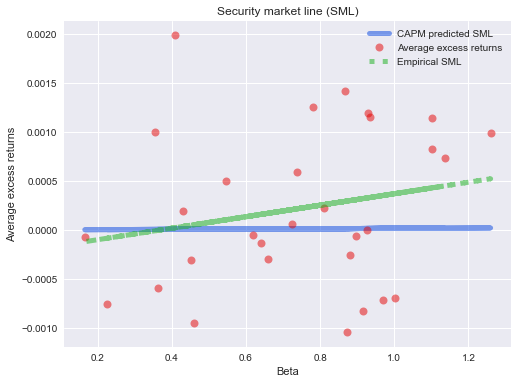

In [12]:
##The SML and CAPM is different than the one from the US
CSR = sm.OLS(AvgR, sm.add_constant(BETA)).fit()

plt.style.use('seaborn')
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1,1,1)

plt.plot(BETA, AvgRHat, color='xkcd:blue', linewidth=5, alpha=0.5)
plt.plot(BETA, AvgR, 'o', color='xkcd:red', alpha=0.5, markersize=8)
plt.plot(BETA, CSR.fittedvalues, ':', color='xkcd:green', alpha=0.5, linewidth=5)
plt.ylabel('Average excess returns')
plt.xlabel('Beta')
plt.title('Security market line (SML)')
plt.legend(['CAPM predicted SML', 'Average excess returns', 'Empirical SML'],loc='best')
plt.show()

### Part 4: Momentum Factor *[15 points]*

In this part, you are going to **replicate** the **cross-sectional momentum strategy** from **Kenneth French Data Library**. 

Momentum is defined as:

$\mathrm{MOM}_{i,t} = \prod_{i=2}^{12}(1+r_{i,t-i})$

Suggested structure of the code:
1. Import **'Stock RET.csv'**.
2. Identify **NYSE size cutoffs (50-50 by median)** for each month.
3. Sort stocks into **small stocks (S, bottom 50)** and **big stocks (B, top 50)**.
4. Compute **momentum** $\mathrm{MOM}_{i,t}$ for each stock-month observation *[5 points]*.
5. Identify **NYSE momentum cutoffs (30-40-30 by percentiles)** for each month.
6. Sort stocks into **loser (L, bottom 30), neutral (N, middle 40), and winner stocks (W, top 30)**.
7. Form **2 by 3 portfolios** ($\mathrm{ME} \times \mathrm{MOM}$) through **unconditional bivariate sorts** *[5 points]*.
8. Compute **momentum strategy returns** over time with: $R_{\scriptstyle{\text{WML}}} = \frac{(R_{\scriptstyle{\text{SW}}} +  R_{\scriptstyle{\text{BW}}})}{2} - \frac{(R_{\scriptstyle{\text{SL}}} + R_{\scriptstyle{\text{BL}}})}{2}$ *[2.5 points]*.
9. With the help of a **bar chart**, compare **your replication** with the one constructed by **Fama-French ('F-F_Momentum_Factor')** *[2.5 points]*.


#### Step1: get the Market Equity data

In [13]:
df= pd.read_csv("Stock_RET.csv")
df.date = pd.to_datetime(df.date, format='%Y%m%d', errors='ignore')+ pd.offsets.MonthEnd(0)

df.EXCHCD = pd.to_numeric(df.EXCHCD, errors='coerce')
df.RET = pd.to_numeric(df.RET, errors='coerce')
df.ME = pd.to_numeric(df.ME, errors='coerce')

df = df.set_index(["date", "PERMNO"])

#### Step2: specify NYSE stock data

In [14]:
#Create a dataframe only containing stocks from nyse
df_nyse = df[df.EXCHCD==1]
df = df.drop(['EXCHCD'], axis=1)

df_nyse = df_nyse.drop(['EXCHCD'], axis=1)
me_nyse = df_nyse.unstack().xs('ME', axis=1)

#### Step3: Identify **NYSE size cutoffs** (50-50 by median)

In [15]:
S_cutoff = pd.to_numeric(me_nyse.quantile(.5, axis=1, numeric_only=False))

#### Step4: Get the market equity portfolio

In [16]:
ME = df.unstack().xs('ME', axis=1)
ME_port = pd.DataFrame(index=ME.index, columns=ME.columns)

ME_port[ME.gt(S_cutoff, axis=0)] = 'Big'
ME_port[ME.le(S_cutoff, axis=0)] = 'Small'

#### Step5: Calculate momentum

In [17]:
RET = df.unstack().xs('RET', axis=1)
RET = RET.apply(pd.to_numeric)

In [18]:
RET += 1
MOM = RET.rolling(11).apply(np.prod).shift(2)

#### Step6: Identify **MOM Cutoff** and construct portfolio

In [19]:
nyse_MOM = (df_nyse.unstack().xs("RET",axis=1)+1).rolling(11).apply(np.prod).shift(2)
MOM_low_30 =  nyse_MOM.quantile(.3,axis=1)
MOM_top_30 =  nyse_MOM.quantile(.7,axis=1)   

In [20]:
MOM_port = pd.DataFrame(index=MOM.index,columns=MOM.columns)

MOM_port[MOM.gt(MOM_top_30,axis=0)]= "Winner"
MOM_port[MOM.lt(MOM_low_30,axis=0)]= "Loser"
MOM_port[MOM.lt(MOM_top_30,axis=0)&MOM.gt(MOM_low_30,axis=0)] = "Neutral"

MOM_port.tail()

PERMNO,10001,10025,10026,10028,10032,10044,10051,10104,10107,10116,...,93418,93420,93422,93423,93426,93428,93429,93433,93434,93436
date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,NaN,NaN,Neutral,Winner,Winner,Loser,Neutral,Neutral,Winner,NaN,...,NaN,Loser,Loser,Loser,Loser,NaN,Neutral,NaN,Neutral,Winner
2020-09-30,NaN,NaN,Loser,Winner,Winner,Loser,Neutral,Neutral,Winner,NaN,...,NaN,Loser,Loser,Loser,Neutral,NaN,Loser,NaN,Neutral,Winner
2020-10-31,NaN,NaN,Loser,Winner,Winner,Loser,Neutral,Neutral,Winner,NaN,...,NaN,Loser,Loser,Loser,Neutral,NaN,Neutral,NaN,Neutral,Winner
2020-11-30,NaN,NaN,Loser,Winner,Neutral,Loser,Loser,Winner,Winner,NaN,...,NaN,Loser,Loser,Loser,Neutral,NaN,Neutral,NaN,Winner,Winner
2020-12-31,NaN,NaN,Neutral,Winner,Neutral,Loser,Loser,Neutral,Winner,NaN,...,NaN,NaN,Loser,Loser,Loser,NaN,Loser,NaN,Neutral,Winner


#### Step7: combine both DataFrame strings to create 2x3 portfolios

In [21]:
TMP = ME_port + MOM_port
ME_MOM_port = pd.DataFrame(index=RET.index)
ME_MOM_port = ME_MOM_port.join(TMP)

ME_MOM_port = ME_MOM_port.ffill(axis=0,limit=11).shift(1)

#### Step8: Calculate the return for each portfolio category

In [22]:
ME_lag = df.unstack().xs('ME', axis=1).shift(1)
unique_port = ['SmallWinner', 'SmallNeutral', 'SmallLoser', 'BigWinner','BigNeutral', 'BigLoser']

RET_port = pd.DataFrame(index=RET.index, columns=unique_port)
N_firm = pd.DataFrame(index=RET.index, columns=unique_port)

for p in unique_port:
    TMP_RET = RET[ME_MOM_port==p].apply(pd.to_numeric)
    TMP_ME = ME_lag[ME_MOM_port==p].apply(pd.to_numeric)

    # do value weighted sum
    TMP_PROD = TMP_RET*TMP_ME
    RET_port[p] = TMP_PROD.sum(axis=1)/TMP_ME.sum(axis=1)
    
    N_firm[p] = TMP_RET.count(axis=1)
    
RET_port = RET_port.dropna()*100
RET_port.head()

,SmallWinner,SmallNeutral,SmallLoser,BigWinner,BigNeutral,BigLoser
date,,,,,,
2017-02-28,99.999439,101.071405,102.112870,100.285925,104.111719,104.347976
2017-03-31,98.747752,100.254337,100.868209,97.907961,100.531013,100.228644
2017-04-30,99.304477,100.224337,100.451123,100.510831,101.399807,100.796039
2017-05-31,96.201842,96.533528,97.682048,101.003113,101.817073,100.459016
2017-06-30,103.640274,103.458597,104.156650,99.839419,100.483784,100.217553


#### Step9: Calculate Momentum factor

In [23]:
MOM_factor = RET_port[["SmallWinner","BigWinner"]].sum(axis=1)/2 - \
RET_port[["SmallLoser","BigLoser"]].sum(axis=1)/2

MOM_factor.name= "MOM"

#### Step10: Compare with dataset

In [24]:
FF_MOM_Factor= pdr.get_data_famafrench("F-F_Momentum_Factor")
FF_MOM_Factor[0]

#FIX THE INDEX SO IN ORDER TO JOIN THEM
MOM_factor.index = MOM_factor.index.strftime("%Y-%m")
FF_MOM_Factor[0].index = FF_MOM_Factor[0].index.strftime("%Y-%m")


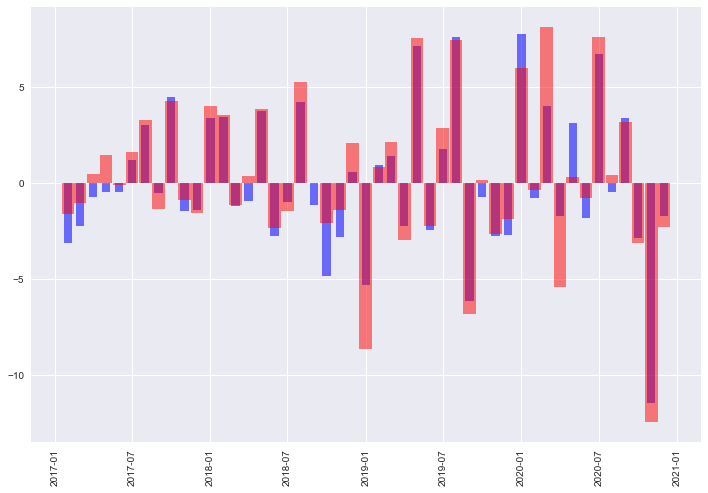

In [25]:
FF_AND_REPLICATE_MOM = FF_MOM_Factor[0].join(MOM_factor)

FF_AND_REPLICATE_MOM.index = pd.to_datetime(FF_AND_REPLICATE_MOM.index)
FF_AND_REPLICATE_MOM.dropna(inplace=True)



plt.figure(figsize=(12,8))
plt.bar(FF_AND_REPLICATE_MOM.index, FF_AND_REPLICATE_MOM.iloc[:,1], width= 20,  alpha=0.55, color='blue')
plt.bar(FF_AND_REPLICATE_MOM.index, FF_AND_REPLICATE_MOM.iloc[:,0],width=30,  alpha=0.5, color='red')
plt.xticks(rotation=90)
plt.show()

In [26]:
FF_AND_REPLICATE_MOM.corr()

,Mom,MOM
Mom,1.000000,0.943819
MOM,0.943819,1.000000


### Part 5: Create your own strategy *[15 points]*

Imagine today is **31 December 2020** (you can use any data available before 2021). You are a group of fund managers managing a quantitative fund with an **investment universe** consists of **index constituents from Part 1**. Your group wants to **design a new investment strategy and implement it starting from 2021**. The work plan is as follows:
1. Form **benchmark portfolios** based on **Indexation (VW, EW, PW)** and **Modern Portfolio Theory (GMVP and MSRP)** *[5 points]*.
2. Create and backtest a **proprietary trading strategy** that aims to **outperform the market index** *[5 points]*.
3. Keep track of the **out-of-sample performance** of **your group's strategy** as well as **benchmark portfolios** and carry out **performance evaluations** using data available in 2021 so far *[5 points]*.

Your team will **build the prototype of the strategy with Python** and the **source code** below will be inspected by the **model validation quant, Douglas Chung**. 

#### Step1. Determine our strategy weights

##### Step1.1. Get data

In [27]:
page = pd.read_html("https://en.wikipedia.org/wiki/DAX")
tickers = page[3].iloc[:,3]

PRC = pd.DataFrame()
ME = pd.DataFrame()

for i in tickers:
     
    data= yf.download(i,interval="1d",start="2020-01-01",end="2020-12-31")
    
    data= pd.DataFrame(data["Adj Close"])
    data.columns= [i]
    PRC= pd.concat([PRC,data],axis=1)
    
    
    stk= yf.Ticker(i)
    
    # get the number of shares
    try:
        stk.info["floatShares"]
    except:
        stk.info["floatShares"]= None
    try:
        stk.info["sharesOutStanding"]
    except:   
        stk.info["sharesOutStanding"] = None

    # get the market equity
    if stk.info["floatShares"]:
        mcap = data * stk.info["floatShares"]

    elif stk.info["sharesOutStanding"]:
        mcap = data * stk.info["sharesOutStanding"]
    else:
        mcap = data * (stk.info["marketCap"]/stk.info["previousClose"])
        
    ME = pd.concat([ME,mcap],axis=1)    
    
# ENR.DE was not in DAX30 until 2020-12, so we dropped it
PRC.drop("ENR.DE",axis=1,inplace=True)   
ME.drop('ENR.DE', axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

##### Step 1.2. Slice **price** and **market equity** dat (get ME portfolio)

In [28]:
me = ME.copy()
cutoff = me.quantile(0.5, axis=1)
port_df = pd.DataFrame(columns=me.columns,index=me.index)

port_df[me.gt(cutoff,axis=0)] = 'Big'
port_df[me.le(cutoff,axis=0)] = 'Small'

# we will calculate momentum after, so we dont need first 13 data
port_df = port_df.iloc[13:,:]

##### Step1.3. Calculate Momentum

In [29]:
prc = PRC.copy()
RET = PRC.pct_change()

tmp_RET = (RET + 1)
tmp_RET = tmp_RET.iloc[1:, :] # delete the first one since it has no return

##### Step1.4. Get Momentum portfolio

In [30]:
MOM = tmp_RET.rolling(11).apply(np.prod).shift(2)

MOM = MOM.apply(pd.to_numeric)
L_cutoff = pd.to_numeric(MOM.quantile(.3,axis=1,numeric_only=False))
H_cutoff = pd.to_numeric(MOM.quantile(.7,axis=1,numeric_only=False))

WL_port = pd.DataFrame(index=RET.index, columns=RET.columns)
WL_port[MOM.gt(H_cutoff, axis=0)] = 'Winner'
WL_port[(MOM.le(H_cutoff, axis=0)) & (MOM.ge(L_cutoff, axis=0))] = 'Neutral'
WL_port[MOM.lt(L_cutoff, axis=0)] = 'Loser'
WL_port.tail()

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,1COV.DE,DAI.DE,DHER.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VOW3.DE,VNA.DE
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-22,Winner,Loser,Winner,Neutral,Loser,Neutral,Winner,Neutral,Winner,Loser,...,Winner,Neutral,Loser,Loser,Neutral,Loser,Neutral,Winner,Winner,Winner
2020-12-23,Winner,Loser,Winner,Neutral,Loser,Neutral,Winner,Loser,Winner,Loser,...,Neutral,Winner,Neutral,Loser,Loser,Loser,Neutral,Neutral,Winner,Winner
2020-12-28,Winner,Loser,Winner,Neutral,Loser,Winner,Winner,Loser,Winner,Loser,...,Winner,Neutral,Neutral,Neutral,Loser,Loser,Neutral,Neutral,Winner,Winner
2020-12-29,Winner,Neutral,Winner,Neutral,Loser,Winner,Winner,Neutral,Winner,Loser,...,Winner,Neutral,Loser,Winner,Neutral,Loser,Neutral,Neutral,Winner,Winner
2020-12-30,Winner,Neutral,Neutral,Neutral,Loser,Winner,Loser,Neutral,Winner,Loser,...,Winner,Winner,Loser,Neutral,Loser,Winner,Neutral,Winner,Neutral,Winner


##### Step1.5. Set rebalance rule

Since the momentum will be updated everyday, and market equity will not change significantly,   
we decide to only get momentum data on the last day of every month. 

In [31]:
WL_port.index = pd.to_datetime(WL_port.index, format='%Y%m%d', errors='ignore')+ pd.offsets.MonthEnd(0)

# store 2020 Feb and months other than Feb's date
other_list = []
feb_list = []

feb = pd.DataFrame()
other = pd.DataFrame()

for i in PRC.index:
    if i.month == 2:
        feb_list.append(i)
    else:
        other_list.append(i)

feb = WL_port[WL_port.index.month == 2]
other = WL_port[WL_port.index.month != 2]

feb.index = feb_list
other.index = other_list

In [32]:
# merge the two dataframes (Feb and Non-Feb)
WL_port = other.merge(feb, how='outer')

# then revise the index to the correct order (Jan, Feb, Mar,....)
all_date = feb_list + other_list
all_date.sort()
WL_port.index = all_date

WL_port.dropna(inplace=True)

##### Step1.6. Combine two cutoff portfolio

In [33]:
ME_MOM_port = port_df + WL_port
ME_MOM_port.tail(5)

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,1COV.DE,DAI.DE,DHER.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VOW3.DE,VNA.DE
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-22,BigLoser,BigNeutral,BigLoser,BigLoser,SmallLoser,SmallWinner,SmallWinner,BigNeutral,SmallWinner,SmallWinner,...,BigLoser,BigNeutral,SmallNeutral,SmallLoser,BigNeutral,SmallWinner,BigNeutral,BigLoser,BigNeutral,BigNeutral
2020-12-23,BigNeutral,BigNeutral,BigLoser,BigLoser,SmallNeutral,SmallWinner,SmallWinner,BigLoser,SmallNeutral,SmallNeutral,...,BigLoser,BigWinner,SmallNeutral,SmallLoser,BigNeutral,SmallWinner,BigNeutral,BigLoser,BigNeutral,BigWinner
2020-12-28,BigLoser,BigNeutral,BigNeutral,BigLoser,SmallNeutral,SmallWinner,SmallWinner,BigLoser,SmallNeutral,SmallLoser,...,BigLoser,BigNeutral,SmallNeutral,SmallLoser,BigNeutral,SmallWinner,BigNeutral,BigLoser,BigNeutral,BigWinner
2020-12-29,BigLoser,BigNeutral,BigLoser,BigLoser,SmallNeutral,SmallWinner,SmallWinner,BigLoser,SmallNeutral,SmallNeutral,...,BigNeutral,BigNeutral,SmallNeutral,SmallLoser,BigLoser,SmallWinner,BigNeutral,BigLoser,BigNeutral,BigWinner
2020-12-30,BigLoser,BigNeutral,BigLoser,BigLoser,SmallNeutral,SmallWinner,SmallWinner,BigNeutral,SmallLoser,SmallLoser,...,BigNeutral,BigNeutral,SmallNeutral,SmallLoser,BigNeutral,SmallWinner,BigNeutral,BigLoser,BigNeutral,BigWinner


##### Step1.7. Backtest our strategy (time frame: 2020.01-2021.12)

In [34]:
ME_lag = me.shift(1)
unique_port = ['SmallLoser', 'SmallNeutral', 'SmallWinner', 'BigLoser','BigNeutral', 'BigWinner']

RET_port = pd.DataFrame(index=RET.index, columns=unique_port)
N_firm = pd.DataFrame(index=RET.index, columns=unique_port)

for p in unique_port:
  TMP_RET = RET[ME_MOM_port==p].apply(pd.to_numeric)
  TMP_ME = ME_lag[ME_MOM_port==p].apply(pd.to_numeric)
  TMP_PROD = TMP_RET*TMP_ME
  RET_port[p] = TMP_PROD.sum(axis=1)/TMP_ME.sum(axis=1)
  N_firm[p] = TMP_RET.count(axis=1)

RET_port = RET_port.dropna()
RET_port.tail()

,SmallLoser,SmallNeutral,SmallWinner,BigLoser,BigNeutral,BigWinner
Date,,,,,,
2020-12-22,0.010071,0.010860,0.011451,0.017082,0.012147,0.000000
2020-12-23,0.015569,0.008505,0.016559,0.015382,0.011479,0.010669
2020-12-28,0.008764,0.023782,0.015438,0.015766,0.012072,0.017181
2020-12-29,0.012295,-0.009225,0.001267,-0.006338,0.001061,0.003356
2020-12-30,-0.000930,-0.004034,-0.007370,-0.003756,-0.001232,-0.005061


##### Step1.8. Visualization of our strategy (backtesting)

Text(0.5, 1.0, 'Backtest: Momentum-Market Equity Strategy on DAX30')

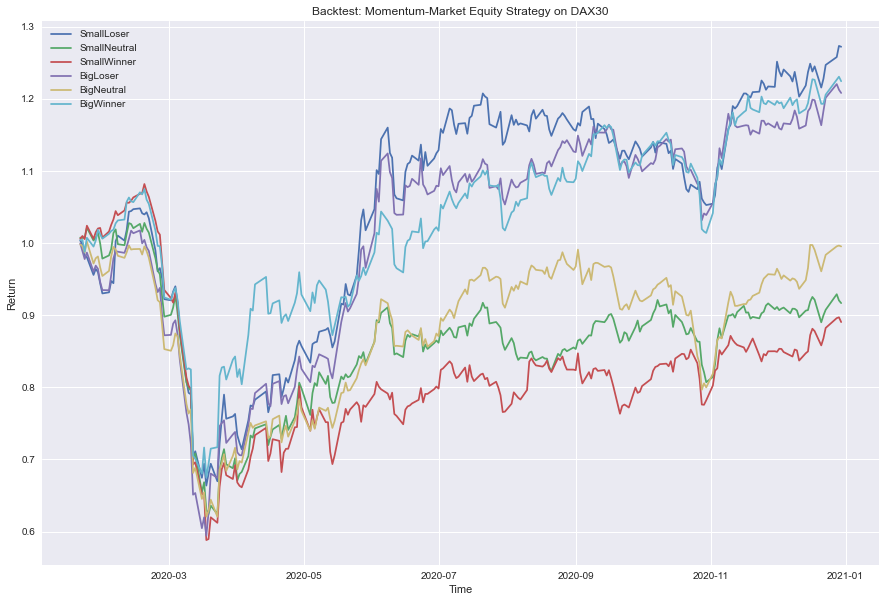

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

tmp = (RET_port.dropna()+1).cumprod()

ax.plot(tmp, label=unique_port)
ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title('Backtest: Momentum-Market Equity Strategy on DAX30')

##### Step1.9. Get our strategy's weights (Identify the weight of each stock on 2020-12-30)

[Explanation]
After backtesting the data for one year, we define our strategy as:  
- **Long ```SmallLoser```, ```BigWinner```, ```BigLoser```** (top 3 best performers on 2020), **Short ```BigNeutral```, ```SmallNeutral```, ```SmallWinner```** (worst 3 performers on 2020)
- How to determine weight: the weight on 2020-12-30   
- How to rank the stocks: the ranking on 2020-12-30

In [36]:
# get the 2020-12-30 rank
last_rank = ME_MOM_port.iloc[-1:, ]

# calculate the weights (using our strategy) on 2021-12-30
me.iloc[-1,:] / me.iloc[-1,:].sum(axis=0)

ADS.DE     0.047639
ALV.DE     0.074296
BAS.DE     0.052855
BAYN.DE    0.042514
BMW.DE     0.027846
CON.DE     0.012176
1COV.DE    0.008628
DAI.DE     0.042737
DHER.DE    0.019241
DBK.DE     0.015099
DB1.DE     0.023261
DPW.DE     0.035791
DTE.DE     0.055249
DWNI.DE    0.001808
EOAN.DE    0.017859
FRE.DE     0.014192
FME.DE     0.012392
HEI.DE     0.005261
HEN3.DE    0.023176
IFX.DE     0.037877
LIN.DE     0.099978
MRK.DE     0.016741
MTX.DE     0.010248
MUV2.DE    0.030517
RWE.DE     0.020495
SAP.DE     0.102646
SIE.DE     0.085708
VOW3.DE    0.032618
VNA.DE     0.031151
Name: 2020-12-30 00:00:00, dtype: float64

##### Step1.10. Identify the **good** stock on 2020-12-30

Definition: Any stock that belongs to ```SmallLoser```, ```BigWinner```, ```BigLoser``` is **good** stock

In [37]:
# identify stocks that we are going to long
filter_ = (last_rank.T['2020-12-30'] == 'SmallLoser') | (last_rank.T['2020-12-30'] == 'BigWinner') | (last_rank.T['2020-12-30'] == 'BigLoser') 
good_rank = list(last_rank.T[filter_].index)

In [38]:
last_date = me.iloc[-1:]
last_date

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,1COV.DE,DAI.DE,DHER.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VOW3.DE,VNA.DE
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,5.105821e+10,7.962810e+10,5.664867e+10,4.556531e+10,2.984411e+10,1.305021e+10,9.247372e+09,4.580396e+10,2.062232e+10,1.618323e+10,...,4.059595e+10,1.071538e+11,1.794282e+10,1.098373e+10,3.270692e+10,2.196584e+10,1.100138e+11,9.185972e+10,3.495920e+10,3.338730e+10


In [39]:
good_weights = {} # store the weight for each stock
sum_me = 0
last_date = me.iloc[-1:]

for c in me.columns:
  if c in good_rank:
    cME = last_date[c]
    sum_me += cME # calculate total market equity

for c in me.columns:
  if c in good_rank:
    good_weights[c] = last_date[c] / sum_me # calculate the value-weighted weight

In [40]:
# make sure the weights add up to 1
sum = 0
for i in good_weights:
  sum += good_weights[i].values[0]
sum 

1.0

### Step1.11. Identify the **bad** stock of each stock on 2020-12-30

Definition: Any stock that belongs to ```BigNeutral```, ```SmallNeutral```, ```SmallWinner``` is **bad** stock

In [41]:
filter_ = (last_rank.T['2020-12-30'] == 'BigNeutral') | (last_rank.T['2020-12-30'] == 'SmallNeutral') | (last_rank.T['2020-12-30'] == 'SmallWinner') 
bad_rank = list(last_rank.T[filter_].index)

In [42]:
bad_weights = {}
sum_me = 0
last_date = me.iloc[-1:]

for c in me.columns:
  if c in bad_rank:
    cME = last_date[c]
    sum_me += cME

for c in me.columns:
  if c in bad_rank:
    bad_weights[c] = last_date[c] / sum_me

In [43]:
sum = 0
for i in bad_weights:
  sum += bad_weights[i].values[0]
sum

0.9999999999999999

#### Step2. Plot the out-of-sample performance

##### Step2.1. Get the weight all together (good and bad stocks' weight)

In [44]:
# merge the two dicts
for ticker, value in (good_weights.items()):
  bad_weights[ticker] = value

weights = bad_weights

##### Step2.2. Get the price data from 2021-01-01 to 2021-12-23

In [45]:
start_date = '2021-01-01'
end_date = '2021-12-22'
#data = yf.download('DAX',start='2017-01-01',end='2021-01-01')

Constituent = list(pd.read_html('https://en.wikipedia.org/wiki/DAX')[3]['Ticker symbol'])
shares = {}
df_2021 = pd.DataFrame()
for ticker in Constituent:
    try:
        df_2021[ticker] = yf.download(ticker, start = start_date, end = end_date)['Close']
    except Exception as e:
        print('Failed to Download or merge : '+ticker)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [46]:
# get the daily return 
ret_2021 = df_2021.pct_change()
ret_2021 = ret_2021.iloc[1:,]
ret_2021.drop(columns=['ENR.DE'], inplace=True)

##### Step2.3. Get the weight dataframe

In [47]:
weight_df = pd.DataFrame(np.nan, index=ret_2021.index, columns=ret_2021.columns)
weight_df.head(2)

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,1COV.DE,DAI.DE,DHER.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VOW3.DE,VNA.DE
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# weight_df will store the weight of the stocks 
for c in weight_df:
  for k, v in weights.items():
    if c == k: # e.g. if 
      weight_df[c] = v[0] 

In [49]:
weight_df.tail()

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BMW.DE,CON.DE,1COV.DE,DAI.DE,DHER.DE,DBK.DE,...,IFX.DE,LIN.DE,MRK.DE,MTX.DE,MUV2.DE,RWE.DE,SAP.DE,SIE.DE,VOW3.DE,VNA.DE
Date,,,,,,,,,,,,,,,,,,,,,
2021-12-15,0.118872,0.123982,0.131888,0.106084,0.046468,0.020319,0.014398,0.071318,0.048012,0.037677,...,0.063209,0.16684,0.027937,0.025572,0.050925,0.034201,0.171293,0.213866,0.054432,0.077731
2021-12-16,0.118872,0.123982,0.131888,0.106084,0.046468,0.020319,0.014398,0.071318,0.048012,0.037677,...,0.063209,0.16684,0.027937,0.025572,0.050925,0.034201,0.171293,0.213866,0.054432,0.077731
2021-12-17,0.118872,0.123982,0.131888,0.106084,0.046468,0.020319,0.014398,0.071318,0.048012,0.037677,...,0.063209,0.16684,0.027937,0.025572,0.050925,0.034201,0.171293,0.213866,0.054432,0.077731
2021-12-20,0.118872,0.123982,0.131888,0.106084,0.046468,0.020319,0.014398,0.071318,0.048012,0.037677,...,0.063209,0.16684,0.027937,0.025572,0.050925,0.034201,0.171293,0.213866,0.054432,0.077731
2021-12-21,0.118872,0.123982,0.131888,0.106084,0.046468,0.020319,0.014398,0.071318,0.048012,0.037677,...,0.063209,0.16684,0.027937,0.025572,0.050925,0.034201,0.171293,0.213866,0.054432,0.077731


##### Step2.4. Visualization of our strategy (out-of-sample)

Text(0.5, 1.0, 'Out of Sample: LONG top three SHORT last three strategy')

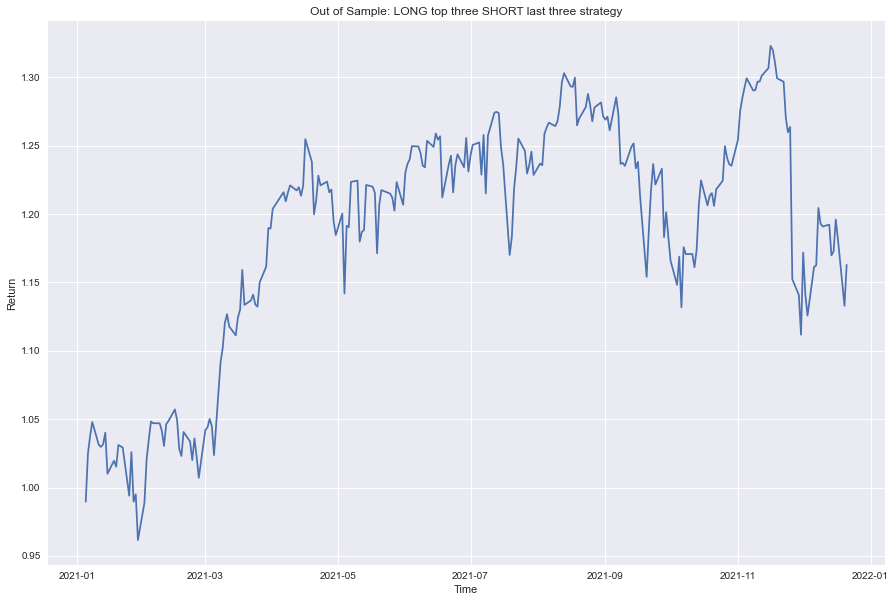

In [50]:
# calculate return
res_df = weight_df * ret_2021
res_df.sum(axis=1)

plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

# dax_ret_2021 = 1 * ((ret_2021).sum(axis=1) + 1).cumprod()
tmp = 1 * ((res_df).sum(axis=1) + 1).cumprod()

ax.plot(tmp)

ax.set_xlabel('Time')
ax.set_ylabel('Return')
ax.set_title('Out of Sample: LONG top three SHORT last three strategy')

##### 

#### Step3. Compare with other strategies

In [51]:
#BENCH MARKS
page = pd.read_html("https://en.wikipedia.org/wiki/DAX")
tickers = page[3].iloc[:,3]

dax = pd.DataFrame()
df_mcap = pd.DataFrame()

for i in tickers:
     
    data= yf.download(i,interval="1d",start="2019-09-01",end="2021-12-31")
    
    data= pd.DataFrame(data["Adj Close"])
    data.columns= [i]
    dax= pd.concat([dax,data],axis=1)
    
    
    stk= yf.Ticker(i)
    try:
        stk.info["floatShares"]
    except:
        stk.info["floatShares"]= None
    try:
        stk.info["sharesOutStanding"]
    except:   
        stk.info["sharesOutStanding"] = None
    if stk.info["floatShares"]:
        mcap = data * stk.info["floatShares"]
    elif stk.info["sharesOutStanding"]:
        mcap = data * stk.info["sharesOutStanding"]
    else:
        mcap = data * (stk.info["marketCap"]/stk.info["previousClose"])
        
    df_mcap = pd.concat([df_mcap,mcap],axis=1)    
    
    
dax.drop("ENR.DE",axis=1,inplace=True)    

PWI = dax.sum(axis=1)
PWI = pd.DataFrame(PWI.rename("PWI"))


EWI= dax.pct_change().mean(axis=1)
EWI[0]=0
EWI += 1
EWI = EWI.cumprod()
EWI = pd.DataFrame(EWI.rename("EWI"))

VWI = df_mcap.sum(axis=1)
VWI = pd.DataFrame(VWI.rename("VWI"))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

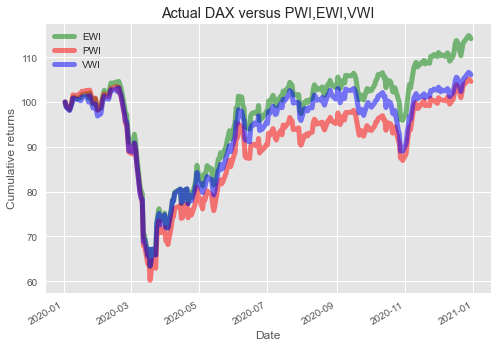

In [52]:
#RETURNS ON 2020 
TS = EWI.join([PWI,VWI]).loc["2020":"2020-12-30"]
TS = TS/TS.iloc[0]*100

plt.style.use("ggplot")
fig = TS.plot(color=["Green","red","blue","yellow"],alpha=.5,linewidth=5)

plt.title("Actual DAX versus PWI,EWI,VWI")
plt.legend(loc="best")
plt.ylabel("Cumulative returns")
plt.show()

In [53]:
df_ER = (dax.pct_change()*100).shift(1)

df_R = dax.pct_change()*100

In [54]:
W_size=60
AvgER_rolling = df_ER.rolling(W_size).mean()
CovER_rolling = df_ER.rolling(W_size).cov()

Backtest_R = pd.DataFrame(index=df_R.index,columns=["GMVP","MSRP","EW","NMSRPnoSS","NGMVPnoSS"])

for d in df_ER.index:
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]
    print(d)
    Backtest_R.loc[d,"GMVP"]= pret(GMVP(S),R)
    Backtest_R.loc[d,"MSRP"]= pret(MSRP(ER,S),R)
  
    Backtest_R.loc[d,"NMSRPnoSS"]= pret(NMSRPnoSS(ER,S).x,R)

Backtest_R.loc[:,"EW"] = df_R.mean(axis=1) 
Backtest_R = Backtest_R.iloc[( W_size):]

2019-09-02 00:00:00
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 4120
            Gradient evaluations: 101
2019-09-03 00:00:00
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 4120
            Gradient evaluations: 101
2019-09-04 00:00:00
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 4120
            Gradient evaluations: 101
2019-09-05 00:00:00
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 4120
            Gradient evaluations: 101
2019-09-06 00:00:00
Iteration limit reached    (Exit mode 9)
            Current function value: nan
            Iterations: 100
            Function evaluations: 4120
        

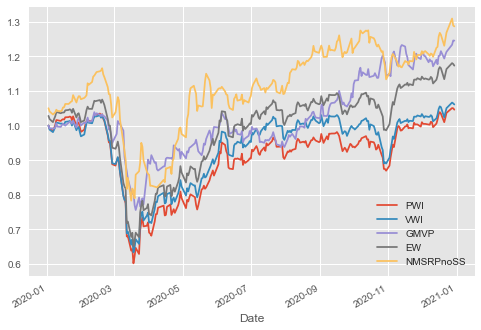

In [55]:
CumRet = (1 + Backtest_R.divide(100)).cumprod()
df = (TS/TS.iloc[0]).join(CumRet)
df.drop(["MSRP","NGMVPnoSS","EWI"],axis=1,inplace=True)
df.plot()
plt.show()

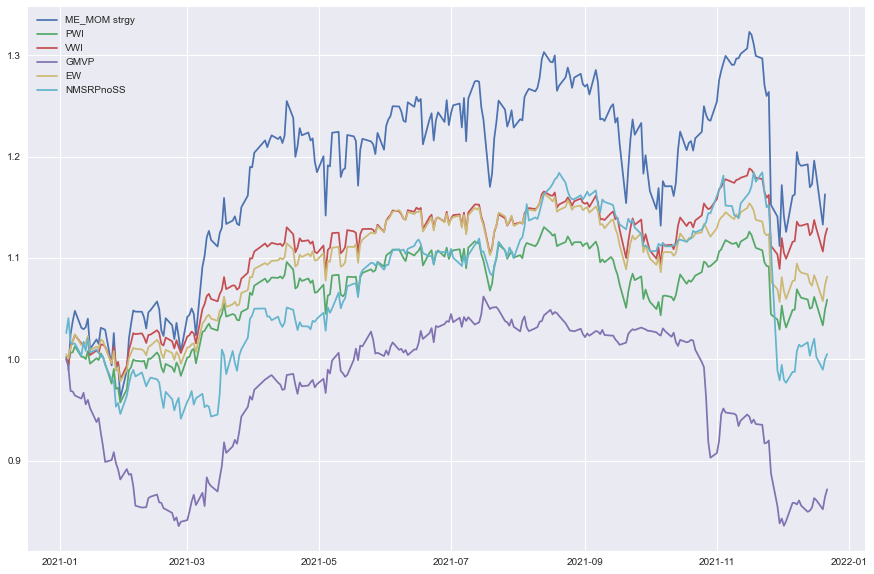

In [56]:
OUT_OF_SAMPLE_TS = EWI.join([PWI,VWI]).loc["2021":]
OUT_OF_SAMPLE_TS = OUT_OF_SAMPLE_TS/OUT_OF_SAMPLE_TS.iloc[0]
OUT_OF_SAMPLE_CUM_RET = (1 + (Backtest_R.loc["2021":]).divide(100)).cumprod()

OUT_OF_SAMPLE_DF = OUT_OF_SAMPLE_TS.join(OUT_OF_SAMPLE_CUM_RET)
OUT_OF_SAMPLE_DF.drop(["NGMVPnoSS","EWI","MSRP"],inplace=True,axis=1)


tmp = 1 * ((res_df).sum(axis=1) + 1).cumprod()


plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)

ax.plot(tmp, label='ME_MOM strgy')
ax.plot(OUT_OF_SAMPLE_DF, label=OUT_OF_SAMPLE_DF.columns)
ax.legend(loc='best')

##### Step4. Strategy Evaluation

In [57]:
final_res = 1 * ((res_df).sum(axis=1) + 1).cumprod()
VAR = (res_df.sum(axis=1) * 100 ).var()
MEAN = (res_df.sum(axis=1) * 100 ).mean()

# risk-free: 0%
SR = (MEAN-0) / (VAR)**0.5
SR

0.042452434808018885

In [58]:
MEAN

0.07754677161028842

In [59]:
STD = (res_df.sum(axis=1) * 100 ).std()
STD

1.8266742993888427

In [60]:
OUT_OF_SAMPLE_DF.columns

Index(['PWI', 'VWI', 'GMVP', 'EW', 'NMSRPnoSS'], dtype='object')

In [61]:
port_eval = pd.DataFrame(columns=OUT_OF_SAMPLE_DF.columns, index=['Mean', 'Std'])
for i in OUT_OF_SAMPLE_DF.columns:
    port_eval.loc['Mean', i] = OUT_OF_SAMPLE_DF[i].mean()
    port_eval.loc['Std', i] = OUT_OF_SAMPLE_DF[i].std()

In [62]:
port_eval

,PWI,VWI,GMVP,EW,NMSRPnoSS
Mean,1.068828,1.109,0.967649,1.096262,1.071854
Std,0.041925,0.051341,0.067311,0.04996,0.069047


In [63]:
final_res.iloc[-1:]

Date
2021-12-21    1.162783
dtype: float64

### Part 6: Presentation *[30 points]*

In a **20-minute sales pitch** (**presentation slides in powerpoint or PDF**), your group should discuss the following:

1. Give an **overview of the investment universe** (e.g. industry compositions, important companies, country-specific issues, market index construction) *[5 points]*.
2. Discuss the **historical risk-expected returns profile** of the investment universe (e.g. GMVP, MSRP, unconstrained and constrained Minimum Variance Frontier, SML) *[5 points]*.
3. Explain the **investment philosophy** behind your group's **proprietary trading strategy** and describe its **construction** *[5 points]*.
4. **Compare and contrast your group's strategy** with other **benchmark strategies** (e.g. buy-and-hold market index, EW portfolio, MPT optimal portfolios, smart betas, and etc.) *[5 points]*.
5. Talk about **implementability** and **potential risk factors** of **your group's strategy** *[5 points]*.
6. Present **your strategy's performance so far in 2021** relative to other **benchmark strategies** *[5 points]*.

#### Bonus *[10 points]*:

Q&A section *[10 points]*.